In [5]:
import os
import sys
parent = os.path.realpath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(parent)
import numpy as np
from databases.sql_connect import create_connection
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy


conn = None
#sns.set_theme()
sns.set_theme()
sns.set(context="paper", style="darkgrid", font="Times New Roman", font_scale=2)
cm = 1/2.54

FONTSIZE = 8

cols ={
    "CML-climate change (GWP 100a)": "Green House\nEmissions\n[kg CO2-eq]",
    "CED - total": "Primary\nEnergy\n[MJ -eq]",
    "ADP-Minerals- Total": "Mineral\nDepletion\n[kg Sb-eq]", 
    "EI-Minerals- Total": "Economic\nImportance\n[kg Sb-eq]",
    "GPR-Minerals- Total":"Geo-Politic\nSupply Risk\n[1E6]", 
    "EDIP-Gold": "Gold\n[mg]",
    "EDIP-Copper": "Copper\n[kg]",
    "ReCiPe Endpoint (E - A) - total (total)": "Total\nImpacts [pts]",
}

level ={"CML-climate change (GWP 100a)": 1,
    "CED - total": 1,
    "ADP-Minerals- Total": 2, 
    "EI-Minerals- Total": 2,
    "GPR-Minerals- Total":2, 
    "EDIP-Gold": 0,
    "EDIP-Copper":0,
    "ReCiPe Endpoint (E - A) - total (total)":3,
}



In [6]:
def generate_upper_lower_limits(mean, shape):
    log_mean = np.log(mean)

    sig1 = 1#0.3186
    sig2 = 2#0.675

    sig1 = sig1*shape
    sig2 = sig2*shape

    # boundaries in a normal distribution
    upper_1 = log_mean + sig1
    lower_1 = log_mean - sig1
    upper_2 = log_mean + sig2
    lower_2 = log_mean - sig2

    # escale the boundaries to the exponential form
    upper_1 = np.exp(upper_1)
    upper_2 = np.exp(upper_2)

    lower_1 = np.exp(lower_1)
    lower_2 = np.exp(lower_2)

    return [lower_2, lower_1, upper_1, upper_2]

In [7]:
ps_ids = [3204, 3215, 4433, 6001]
pallette_c = "Greens"
#ps_ids=[3204]

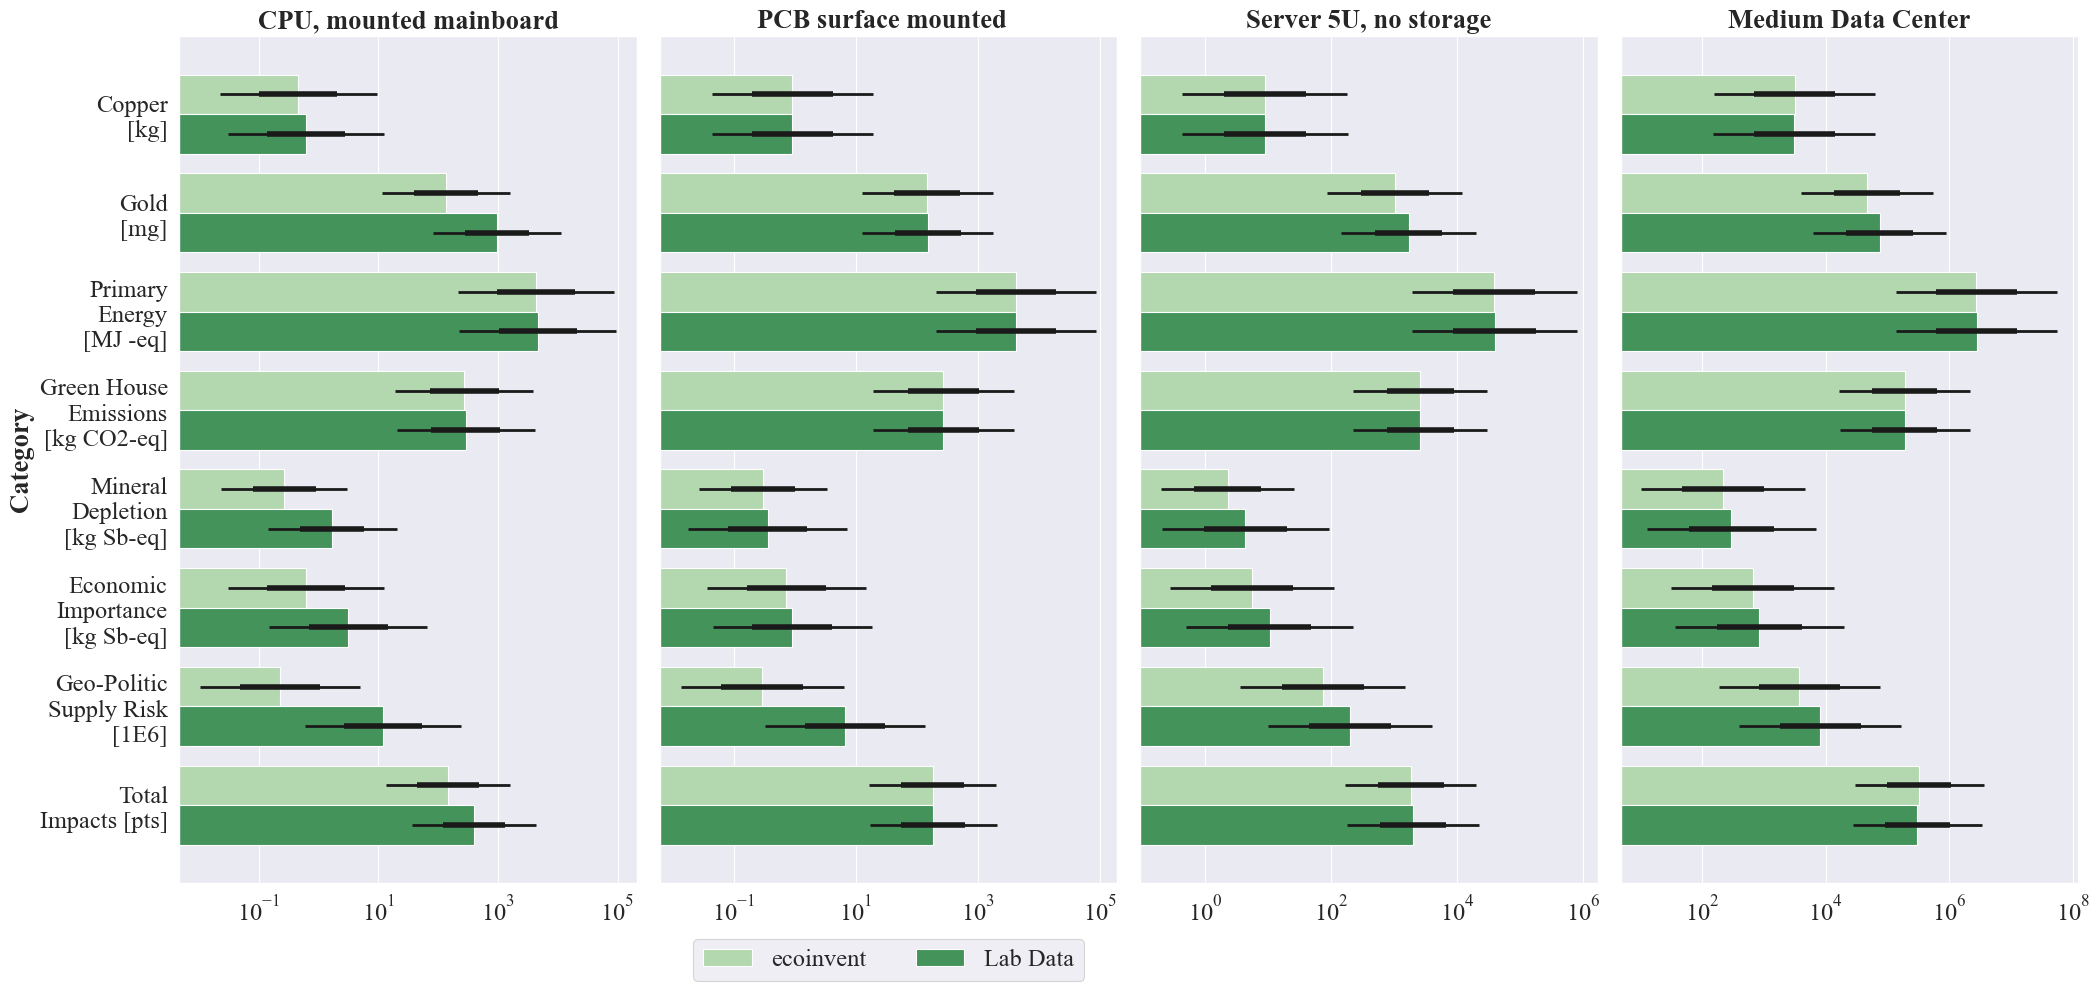

In [8]:

fig, axes = plt.subplots(1, 4, figsize=(24.5, 11))

j = 0
for ps in ps_ids:
    ax = axes[j]

    DB_BASE =  os.path.join(parent,"databases", "TEMPRO_DB220502_Base.db") 
    DB_CORR =  os.path.join(parent,"databases", "TEMPRO_DB230416_Corr.db")
    GROUP = ps-ps % 1000
    dfs = []
    i=0
    for db in [DB_BASE, DB_CORR]:
        conn = create_connection(db)
        query = f'SELECT * FROM [{GROUP}LCAResults]'
        df_lca = pd.read_sql_query(query, conn)
        df_lca = df_lca[df_lca["ProductSystemID"] == ps]
        df_lca.dropna(inplace=True)
        df_lca = df_lca[df_lca["Category"].isin(list(cols.keys()))]
        df_lca.set_index("ProductSystemID")
        i+=1
        conn.close()
        dfs.append(df_lca)
    ps_name = list(df_lca["ProductSystemName"])[0]
    if ps_name == "KDO-IT":
        ps_name ="IT-System"
    title = ps_name
    if title == "KDO":
        title = "Medium Data Center"
    ax.set_title(title, fontweight='bold')
    df_base = dfs[0]
    df_corr = dfs[1]

    #df_base["Result"] = df_base["Result"]/df_corr["Result"]
    #df_corr["Result"] = df_corr["Result"]/df_corr["Result"]

    df_base["Source"] = "ecoinvent"
    df_corr["Source"] = "Lab Data"

    df_total = pd.concat(dfs, ignore_index=True)

    for idx in df_total.index:
        if df_total.at[idx,"Category"] == "EDIP-Gold":
            df_total.at[idx,"Result"]=df_total.at[idx,"Result"]*1000000

        if df_total.at[idx,"Category"] == "GPR-Minerals- Total":
            df_total.at[idx,"Result"]=df_total.at[idx,"Result"]/1000000

    df_total["lower_2"] = np.nan
    df_total["lower_1"] = np.nan
    df_total["upper_1"] = np.nan
    df_total["upper_2"] = np.nan

    for idx in df_total.index:
        limits = generate_upper_lower_limits(
            df_total.at[idx, "Result"], df_total.at[idx, "Uncertainty"])
        df_total.at[idx, "lower_2"] = limits[0]
        df_total.at[idx, "lower_1"] = limits[1]
        df_total.at[idx, "upper_1"] = limits[2]
        df_total.at[idx, "upper_2"] = limits[3]

    df_total.drop(columns=["ID", "ImpactID", "Method",
                  "DataQuality"], inplace=True)
    
    ## here I have to multiply 

    df_total["lvl"]=np.nan

    for idx in df_total.index:
        df_total.at[idx, "lvl"] = level[df_total.at[idx, "Category"]]
        df_total.at[idx, "Category"] = cols[df_total.at[idx, "Category"]]

    df_total.sort_values(by="lvl", ascending=True, inplace=True)    
    df_try_upper = deepcopy(df_total)

    x_col = "Result"
    y_col = "Category"
    hue_col = "Source"
    low_col = "lower_1"
    high_col = "upper_1"
    low_col_2 = "lower_2"
    high_col_2 = "upper_2"

    sns.barplot(x=x_col,
                y=y_col,
                hue=hue_col,
                data=df_try_upper, orient="h", ax=ax,
                palette=pallette_c
                )

    for (h, g), pos in zip(df_try_upper.groupby(hue_col), [0.2, -0.2]):
        err_2 = g[[low_col_2, high_col_2]].subtract(
            g[x_col], axis=0).abs().values
        y_2 = np.arange(len(g[y_col].unique()))+pos
        ax.errorbar(x=g[x_col], y=y_2, xerr=err_2.T, fmt='none',
                    capsize=0, ecolor='k', elinewidth=2)

        err = g[[low_col, high_col]].subtract(g[x_col], axis=0).abs().values
        y = np.arange(len(g[y_col].unique()))+pos
        ax.errorbar(x=g[x_col], y=y, xerr=err.T, fmt='none',
                    capsize=0, ecolor='k', elinewidth=4)

    ax.set_xscale('log')
    ax.set_ylabel("Category", fontweight='bold')

    if j != 0:
        ax.set_yticklabels([])
        ax.yaxis.set_visible(False)
    if j != 3:
        ax.get_legend().remove()
    else:
        plt.legend(bbox_to_anchor=(-1.6,-0.13), loc="lower center", ncols=2)

    ax.set_xlabel("")
    j += 1

    # plt.yticks(rotation=90)
    # plt.xticks(rotation=90)
fig.savefig("DQ_Comparison/Data Quality Comparison.png",bbox_inches='tight', dpi=900)
plt.subplots_adjust(wspace=0.05)

#plt.close()